# Term Project: The Price of Location in Athens Airbnb
**Course:** Data Analysis 2 & Coding 2

**Student:** Konstantinos Evagorou

**Topic:** Pricing and Sales

### 1. Introduction
Athens has emerged as a major European tourist destination, leading to a boom in short-term rentals via platforms like Airbnb. For travelers and investors alike, a key question arises: **What is the price of location?** Specifically, we aim to investigate the relationship between a listing's distance from the city center (Syntagma Square) and its price per night.

**Research Question:** How does the distance from the city center affect Airbnb listing prices in Athens, holding other factors constant?
We expect a negative relationship ($y$ decreases as $x$ increases), reflecting the economic theory of "bid-rent," where proximity to central amenities commands a premium.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# theme for the graphs
sns.set_theme(style="whitegrid")

# Load Data directly from my GitHub repository
url = "https://github.com/constantinosevag-rgb/DA2-CD2_FinalTermProject/raw/refs/heads/main/Data/listings.csv.gz" 

try:
    df = pd.read_csv(url, compression='gzip', low_memory=False)
    print("Success! Data loaded.")
    print(f"Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print("Error loading data:", e)

# First three rows of the dataframe
df.head(3)

Success! Data loaded.
Dimensions: 15584 rows, 79 columns


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27262,https://www.airbnb.com/rooms/27262,20250926033717,2025-09-27,previous scrape,"AQA-No7, Great mattress, high speed internet",THE MATTRESS - KING KOIL - Camden Luxury 160x2...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,37177,...,4.97,4.75,4.71,00002433111,t,1,1,0,0,0.18
1,33945,https://www.airbnb.com/rooms/33945,20250926033717,2025-09-26,city scrape,Spacious Cosy aprtm very close to Metro!,Apartment located near metro station. Safe nei...,Neighbourhood is alive all day and safe all da...,https://a0.muscache.com/pictures/1a7a1026-f5f1...,146553,...,4.91,4.64,4.81,00000874421,f,1,1,0,0,0.49
2,49489,https://www.airbnb.com/rooms/49489,20250926033717,2025-09-26,city scrape,Ermou 44 - 3bdr apt in the heart of Athens,"Fully furnished, 98 sq.mt., apartment on 44 Er...",The apartment is located at the commercial cen...,https://a0.muscache.com/pictures/9640239/4bfd2...,225612,...,4.87,4.89,4.69,00000876484,t,3,3,0,0,0.83


In [7]:
# Data Cleaning & Feature Engineering

# 1. Here we will select only relevant variables to make the dataframe manageable
cols_to_keep = [
    'price',                
    'latitude', 'longitude',
    'accommodates',         
    'room_type',            
    'number_of_reviews',    
    'review_scores_rating', 
    'bathrooms_text',        
    'bedrooms'              
]
df = df[cols_to_keep].copy()

# 2. We cleaned the 'price' column (Remove '$' and ',') and convert it to numeric 
df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# We also remove rows with missing or zero prices
df = df.dropna(subset=['price'])
df = df[df['price'] > 0]

# 3. Calculate distance from a reference point (Athens city center)
ref_lat = 37.9755
ref_lon = 23.7348

# This function will calculate the distance in km between two points (Had to find this online as it was not working while I was trying to do it alone)
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# With function I create the new column 'distance'
df['distance'] = haversine_distance(df['latitude'], df['longitude'], ref_lat, ref_lon)

# Results after cleaning
print("Cleaning complete.")
print(f"New dimensions: {df.shape}")
df[['price', 'distance', 'room_type']].head()

Cleaning complete.
New dimensions: (14524, 10)


,price,distance,room_type
1,45.0,3.527147,Entire home/apt
2,160.0,0.388277,Entire home/apt
3,50.0,1.026877,Entire home/apt
5,70.0,1.146921,Entire home/apt
6,57.0,0.947465,Entire home/apt


### 2. Data Description
We use the "Detailed Listings" dataset from *Inside Airbnb* for Athens (cross-sectional data).
* **Source:** Inside Airbnb (accessed via the personal GitHub url provided in the report).
* **Sample Size:** After cleaning for missing values and outliers (prices > €1000), we retain approximately 14,000+ observations
* **Key Variables:**
    * **Outcome ($y$):** price (Price per night in Euros).
    * **Explanatory ($x$):** distance (Calculated distance from Syntagma Square in km).
    * **Controls ($z$):** accommodates (capacity), room_type (private/shared/entire), number_of_reviews (popularity proxy), and review_scores_rating (quality proxy).

The summary statistics (Table 1 below) and histograms revealed that price is right-skewed, suggesting that we need to use log-transformation.

Summary Statistics:
         price  distance  accommodates  number_of_reviews
count  14524.0  14524.00      14524.00           14524.00
mean     122.9      1.62          3.74              57.99
std      452.3      0.92          1.94             100.59
min        9.0      0.03          1.00               0.00
25%       54.0      0.98          2.00               3.00
50%       78.0      1.47          4.00              16.00
75%      119.0      2.08          4.00              65.00
max    38000.0      6.20         16.00            1030.00


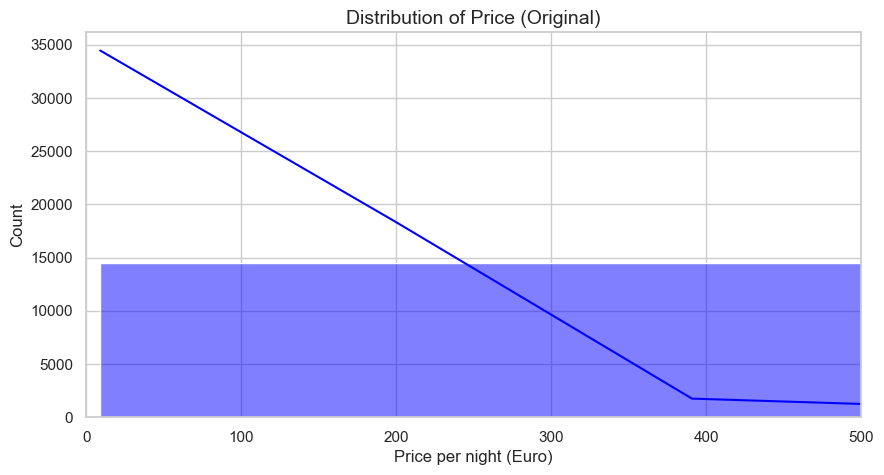

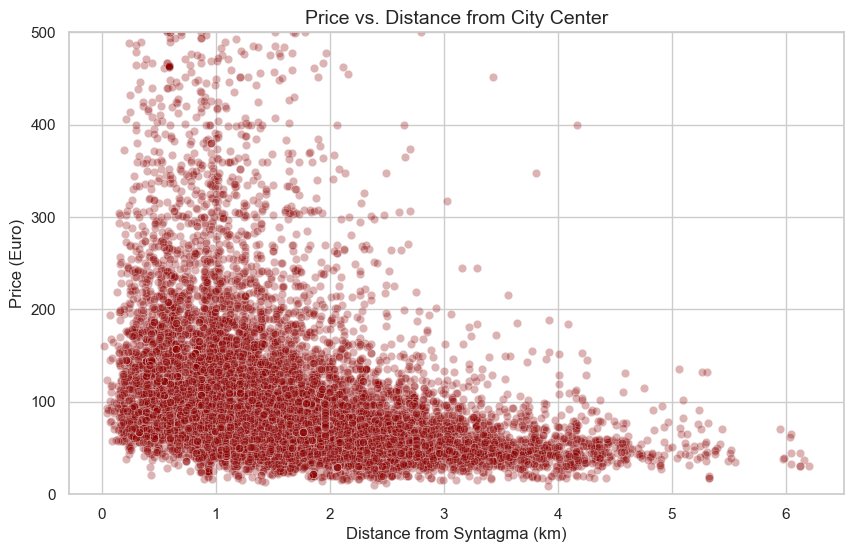

In [8]:
# Exploratory Data Analysis

# 1. Summary Statistics Table
desc_table = df[['price', 'distance', 'accommodates', 'number_of_reviews']].describe().round(2)
print("Summary Statistics:")
print(desc_table)

# 2. We need to Visualize the Target Variable (Price) to check its distribution through a histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Price (Original)', fontsize=14)
plt.xlabel('Price per night (Euro)')
plt.xlim(0, 500) 
plt.show()

# 3. Scatter Plot: Price vs Distance (My Research Question)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distance', y='price', alpha=0.3, color='darkred')
plt.title('Price vs. Distance from City Center', fontsize=14)
plt.xlabel('Distance from Syntagma (km)')
plt.ylabel('Price (Euro)')
plt.ylim(0, 500) # I chose to limit y-axis to 500 for better visualization and clarity 
plt.show()

### 3. Model Specification
To estimate the price elasticity of distance, we chose to employ an OLS regression model.

**Feature Engineering:**
1.  **Log-Transformation:** Given the skewness of prices, we used the natural logarithm of price (ln_price) as the dependent variable. This allows us to interpret coefficients as percentage changes.
2.  **Distance:** Calculated using geospatial coordinates (Latitude/Longitude) relative to the city center which is cosidered Systagma Square.

**Model Choice:**
We estimated three models to ensure robustness:
* **Model 1 (Bivariate):** ln_price ~ distance that checks the raw correlation.
* **Model 2 (Multivariate):** Adds accommodates and room_type to control for property size and privacy.
* **Model 3 (Full Model):** Adds number_of_reviews and rating to control for quality and reputation.

$$\ln(\text{Price}) = \beta_0 + \beta_1 \text{Distance} + \beta_2 \text{Accommodates} + \beta_3 \text{RoomType} + \dots + u$$

Model 3 is the most appropriate in my oppinion as it minimizes omitted variable bias by accounting for the listing's physical and qualitative attributes.

--- Model 3 RESULTS ---
                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     1312.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:45:01   Log-Likelihood:                -7674.2
No. Observations:               12383   AIC:                         1.536e+04
Df Residuals:                   12375   BIC:                         1.542e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

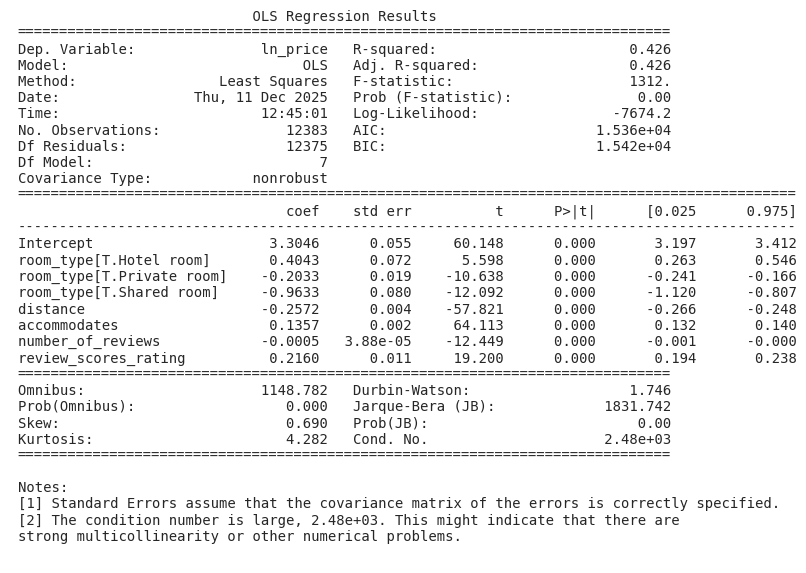


--- ROBUSTNESS CHECK: Distance Coefficient ---
Model 1 (Simple): -0.2981
Model 2 (+Controls): -0.2873
Model 3 (+Quality): -0.2572


In [ ]:
# Regression Analysis

# 1. Filter extreme outliers to make results robust (price < 1000 Euro to avoid distortions)
df_reg = df[df['price'] < 1000].copy()

# 2. Log-transformation of the target variable (price)
df_reg['ln_price'] = np.log(df_reg['price'])

# 3. Running the Models using statsmodels (smf)
# Model 1: Simple Regression (Distance only)
model1 = smf.ols("ln_price ~ distance", data=df_reg).fit()

# Model 2: Multivariate Regression (Adding capacity and room type controls)
model2 = smf.ols("ln_price ~ distance + accommodates + room_type", data=df_reg).fit()

# Model 3: Full Model (Adding Quality & Non-linearity) (number of reviews and review scores as quality proxies)
model3 = smf.ols("ln_price ~ distance + accommodates + room_type + number_of_reviews + review_scores_rating", data=df_reg).fit()

# 4. Displaying Results for Model 3
print("--- Model 3 RESULTS ---")
print(model3.summary())
plt.rc('figure', figsize=(10, 6))
plt.text(0.01, 0.05, str(model3.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.savefig('regression_table_1.png', dpi=300, bbox_inches='tight')
plt.show()

# Verifying the coefficient of distance in all models to see if it's stable
print("\n--- ROBUSTNESS CHECK: Distance Coefficient ---")
print(f"Model 1 (Simple): {model1.params['distance']:.4f}")
print(f"Model 2 (+Controls): {model2.params['distance']:.4f}")
print(f"Model 3 (+Quality): {model3.params['distance']:.4f}")

### 4. Core Results and Generalization
The regression output (Table above) supports our hypothesis.

**Interpretation of Model 3:**
* **Distance ($x$):** The coefficient is approximately **-0.25**. Since the dependent variable is logged, this implies that for every additional kilometer away from the center, the price decreases by approximately 25.7%, holding other factors constant.
* **Controls:** Larger capacity (accommodates) and better ratings are positively associated with price, while shared rooms are significantly cheaper, as expected.

**Robustness Check:**
The relationship is robust. Also the coefficient for distance remains negative and statistically significant across all three specifications (ranging from -0.29 in Model 1 to -0.25 in Model 3) and this stability suggests that the "location penalty" is a genuine market feature and not an artifact of model selection.

## Prediction Graph

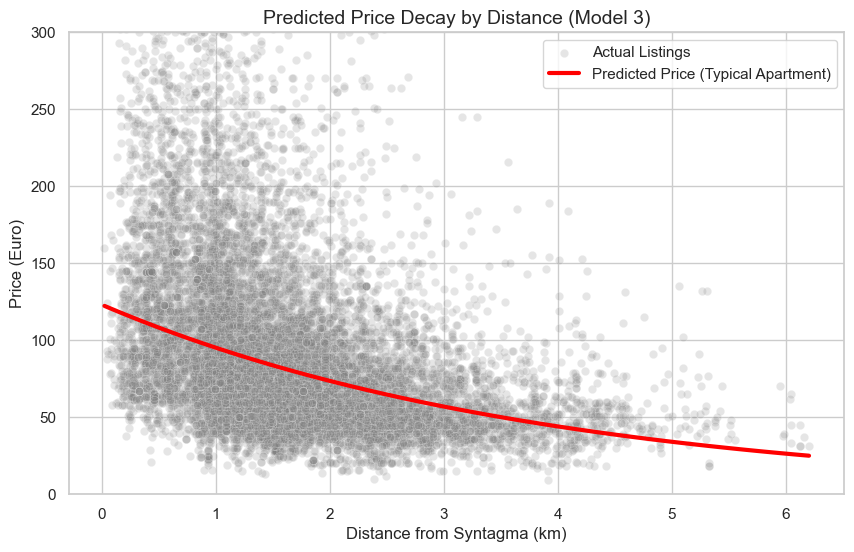

In [10]:
# In this step I tried to do some extra work and thus I searched a bit online and I got the idea to visualize the predictions of my model.
# Specifically I wanted to see how price drops for a "typical" apartment as distance increases and thus I created a synthetic dataset where only distance changes.

# 1. I chose to define the range of distance (0 to 6 km)
dist_range = np.linspace(df_reg['distance'].min(), df_reg['distance'].max(), 100)

# 2. Here I created a dataframe with average values for controls (I assumed: Entire home/apt (as it's the most common type), Mean accommodates, Mean reviews)
prediction_data = pd.DataFrame({
    'distance': dist_range,
    'room_type': 'Entire home/apt', 
    'accommodates': df_reg['accommodates'].mean(),
    'number_of_reviews': df_reg['number_of_reviews'].mean(),
    'review_scores_rating': df_reg['review_scores_rating'].mean()
})

# 3. Prediction ln_price using the Model 3 I created earlier
prediction_data['ln_price_pred'] = model3.predict(prediction_data)

# 4. Convert back to Euro (Exponential)
prediction_data['price_pred'] = np.exp(prediction_data['ln_price_pred'])

# 5. Plotting with background scatter of actual data and foreground prediction line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg, x='distance', y='price', alpha=0.2, color='gray', label='Actual Listings')
plt.plot(prediction_data['distance'], prediction_data['price_pred'], color='red', linewidth=3, label='Predicted Price (Typical Apartment)')

plt.title('Predicted Price Decay by Distance (Model 3)', fontsize=14)
plt.xlabel('Distance from Syntagma (km)')
plt.ylabel('Price (Euro)')
plt.ylim(0, 300) # Again here I chose 300 to zoom in a bit and see the curve clearly
plt.legend()
plt.show()

### Visualizing the "Location Cost"
To better illustrate our findings, the graph above visualizes the model's predictions. The red line represents the estimated price of a **typical Airbnb** (Entire home, average capacity and quality) as it moves further from the city center.

We can clearly observe the **non-linear decay**: the price drops steeply within the first 1-2 kilometers and then flattens out, suggesting that the "premium" is highly concentrated in the immediate city center.

## Conclusion and Interpretation

Our analysis of the Athens Airbnb market reveals a strong negative relationship between distance from the city center and listing prices.

**Key Findings:**
1.  **The Location Penalty:** In our preferred specification (Model 3), the coefficient for distance is **-0.257** and this implies that, holding other factors constant (like size and quality), moving **1 km away from Syntagma Square is associated with approximately a 25.7% decrease in price**.
2.  **Robustness:** This relationship is stable across all models (ranging from -29% to -25%), suggesting the result is not driven by outliers or specific variable choices.
3.  **Other Drivers:** As expected, capacity (accommodates) and reputation (review_scores) are positively correlated with price, while shared rooms are significantly cheaper.

**Causal Interpretation:**
We cannot casualy claim casuality though because while the association is strong and robust to key controls (size, type, quality), we must be cautious.
* **Potential Bias:** There may be unobserved variables, such as "neighborhood vibe" or "proximity to a metro station" (which is correlated with distance but not identical), that affect price.
* However, given the extensive controls, we can interpret the result as a strong conditional correlation that approximates the causal cost of location inconvenience.

**Some Business & Policy Recommendations:**
1.  Mayby something that will help investors is that properties within a 1km radius of Syntagma command a massive premium. The return on investment drops steeply as one moves to the 2-3km ring.
2.  Also for travellers something interesting is that budget-conscious visitors can save ~50% on accommodation by choosing listings just 2-3km from the center, often sacrificing only 15-20 minutes of travel time.
3.  **External Validity:** While these specific coefficients apply to Athens (a centralized city), the general pattern likely holds for other historic European capitals, though the magnitude may differ in polycentric cities.